In [498]:
import os
import datetime as dt
import math

import random as python_random

from matplotlib import pyplot as plt
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (14,7)

import seaborn as sns

import numpy as np
import pandas as pd

import yfinance as yf

import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

from keras.models import Model
from keras.models import Sequential
from keras import optimizers
from keras.layers import Activation,Dropout,Dense,LSTM,BatchNormalization,Input,Bidirectional
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

In [499]:
def MAPE(y_hat,y_pred):
    mape = np.mean(np.abs((y_hat - y_pred)/y_hat))
    return "{:.2%}".format(mape)


In [500]:
def RMSE(y_hat,y_pred):
    MSE = np.square(np.subtract(y_hat,y_pred)).mean() 
    return math.sqrt(MSE)

In [501]:
tf.__version__

'2.4.1'

In [502]:
phys_dev=tf.config.list_physical_devices("GPU")
if len(phys_dev)!=0:
    tf.config.experimental.set_memory_growth(phys_dev[0],True)    
    print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [503]:
#PARAMETERS
EPOCHS=30
BATCH_SIZE=256
RANDOMSEED=123
SELECTED_STOCK='GME'

In [504]:
np.random.seed(RANDOMSEED)
python_random.seed(RANDOMSEED)
tf.random.set_seed(RANDOMSEED)

In [505]:
stock=yf.Ticker(SELECTED_STOCK).history(start='2010-01-01',end='2021-01-01')

In [506]:
from sklearn.linear_model import LinearRegression
x=np.arange(0,len(stock)).reshape(-1,1) 
y=stock.Close.values.reshape(-1,1)
regressor=LinearRegression().fit(x,y)
slope=regressor.coef_
var=stock.Close.var()
mean=stock.Close.mean()
range_=stock.Close.max()-stock.Close.min()
print('\n'.join([
    f'Close price variance: {var}',
    f'Close price mean: {mean}',
    f'Close price regression slope: {slope[0]}',
    f'Close price range: {range_}']))

Close price variance: 74.20312021295663
Close price mean: 18.2743044885057
Close price regression slope: [-0.00347882]
Close price range: 38.45089650154114


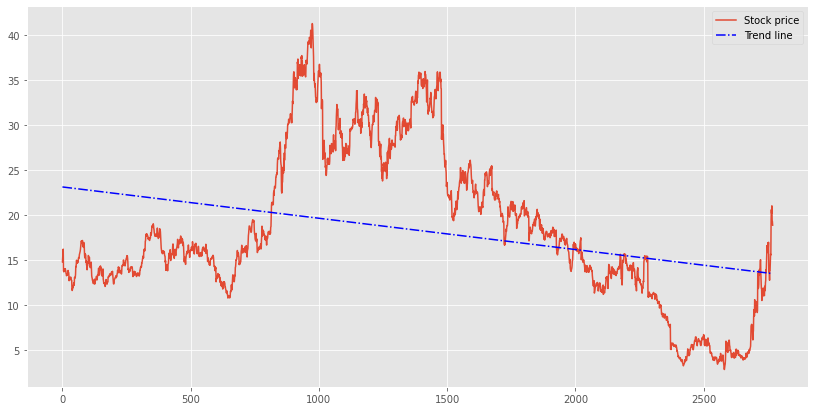

In [507]:
plt.plot(x,y,label='Stock price')
plt.plot(x,regressor.coef_*x+regressor.intercept_,'b-.',label='Trend line')
plt.legend()
plt.show()

In [508]:
class Dataset():
  def __init__(self, data, target='Close',timeseries=True,scale=True,look_forw=1,look_back=20,test_size=0.2):
    #Store the raw data.    
    self.split=int(len(data)*(1-test_size))
    self.Scaler=None
    self.target_col=data.columns.get_loc(target)
    self.look_forw = look_forw
    self.look_back=look_back
    self.train_dates=data.iloc[:self.split,:].index
    self.test_dates=data.iloc[self.split-self.look_back:,:].index

    #self.Data=data.dropna(subset=['Close'],how='any')   
    
    self.Train = np.array(data.iloc[:self.split,:])
    self.Test = np.array(data.iloc[self.split-self.look_back:,:])

    if timeseries==True:
      self.Train=self.Train[:,self.target_col].reshape(-1,1)
      self.Test=self.Test[:,self.target_col].reshape(-1,1)  
    
    if scale==True:
      self.Scaler=MinMaxScaler(feature_range = (0, 1))
      self.Scaler=self.Scaler.fit(self.Train)
    
      self.Train=self.Scaler.transform(self.Train)
      self.Test=self.Scaler.transform(self.Test)
     
    self.X_train_seq=[]
    self.y_train_seq=[]
    for i in range(self.look_back,len(self.Train)):
            self.X_train_seq.append(self.Train[i-self.look_back:i,:])
            
            if timeseries==True:
              self.y_train_seq.append(self.Train[i])
            else:
              self.y_train_seq.append(self.Train[i,self.target_col])

    self.X_train_seq=np.array(self.X_train_seq)
    self.y_train_seq=np.array(self.y_train_seq)

    self.X_train_seq=self.X_train_seq.reshape(self.X_train_seq.shape[0],self.X_train_seq.shape[1],self.X_train_seq.shape[2])

    self.X_test_seq=[]
    for i in range(self.look_back,len(self.Test)):
            self.X_test_seq.append(self.Test[i-self.look_back:i,:])
            
    self.X_test_seq=np.asarray(self.X_test_seq)
    self.X_test_seq=self.X_test_seq.reshape(self.X_test_seq.shape[0],self.X_test_seq.shape[1],self.X_test_seq.shape[2])

    print(self.__repr__())

  def __repr__(self):
    return '\n'.join([
    f'Original train and test{self.Train.shape,self.Test.shape}',
    f'X train size {self.X_train_seq.shape}',
    f'Y train size: {self.y_train_seq.shape}',
    f'X test size: {self.X_test_seq.shape}'])

In [509]:
short_data=Dataset(stock,look_back=1,timeseries=True)
med_data=Dataset(stock,look_back=60,timeseries=True)
long_data=Dataset(stock,look_back=120,timeseries=True)
true_stock=stock.Close[long_data.split:].values

Original train and test((2216, 1), (555, 1))
X train size (2215, 1, 1)
Y train size: (2215, 1)
X test size: (554, 1, 1)
Original train and test((2216, 1), (614, 1))
X train size (2156, 60, 1)
Y train size: (2156, 1)
X test size: (554, 60, 1)
Original train and test((2216, 1), (674, 1))
X train size (2096, 120, 1)
Y train size: (2096, 1)
X test size: (554, 120, 1)


In [510]:
def LSTM_model(input_shape,neurons,layer_num=2):
    lstm_model = Sequential()
    if layer_num==1:
        lstm_model.add(LSTM(units=neurons, return_sequences=False,input_shape=input_shape))
    if layer_num==2:
        lstm_model.add(LSTM(units=neurons, return_sequences=True,input_shape=input_shape))
        lstm_model.add(LSTM(units=neurons, return_sequences=False))
    elif layer_num==4:
        lstm_model.add(LSTM(units=neurons, return_sequences=True,input_shape=input_shape))
        lstm_model.add(LSTM(units=neurons, return_sequences=True))
        lstm_model.add(LSTM(units=neurons, return_sequences=False))
    
    lstm_model.add(Dense(units=1,activation='linear'))
        
    
    #defined_metrics = [tf.keras.metrics.MeanSquaredError(name='MSE')]
    
    # Compile the model
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    lstm_model.compile(optimizer=optimizer,loss=['mse'],metrics=['accuracy'])
    
    return lstm_model

In [511]:
LSTM_Models={}
LSTM_Preds={}

In [512]:
neurons=10

keras.backend.clear_session()
short_shallow_lstm=LSTM_model(input_shape=(short_data.look_back,short_data.X_train_seq.shape[2]),neurons=neurons,layer_num=2)

es=EarlyStopping(monitor='val_loss',min_delta=1e-10,patience=10,verbose=1)
rlr=ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=10,verbose=1)
mcp=ModelCheckpoint(filepath='weights.h5',monitor='val_loss',verbose=1,save_best_only=True,save_weights_only=True)
tb=TensorBoard('logs')

short_shallow_lstm_hist=short_shallow_lstm.fit(short_data.X_train_seq,short_data.y_train_seq,
                epochs=EPOCHS,
                batch_size=BATCH_SIZE,
                shuffle=False,
                verbose=0,
                validation_split=0.2)

keras.backend.clear_session()
med_shallow_lstm=LSTM_model(input_shape=(med_data.look_back,med_data.X_train_seq.shape[2]),neurons=neurons,layer_num=2)

med_shallow_lstm_hist=med_shallow_lstm.fit(med_data.X_train_seq,med_data.y_train_seq,
                epochs=EPOCHS,
                batch_size=BATCH_SIZE,
                shuffle=False,
                verbose=0,
                validation_split=0.2)

keras.backend.clear_session()
long_shallow_lstm=LSTM_model(input_shape=(long_data.look_back,long_data.X_train_seq.shape[2]),neurons=neurons,layer_num=2)

long_shallow_lstm_hist=long_shallow_lstm.fit(long_data.X_train_seq,long_data.y_train_seq,
                epochs=EPOCHS,
                batch_size=BATCH_SIZE,
                shuffle=False,
                verbose=0,
                validation_split=0.2)


keras.backend.clear_session()
long_deep_lstm=LSTM_model(input_shape=(long_data.look_back,long_data.X_train_seq.shape[2]),neurons=neurons,layer_num=4)

long_deep_lstm_hist=long_deep_lstm.fit(long_data.X_train_seq,long_data.y_train_seq,
                epochs=EPOCHS,
                batch_size=int(BATCH_SIZE/2),
                shuffle=False,
                verbose=0,
                validation_split=0.2)

LSTM_Models['10 neuron']=[short_shallow_lstm_hist,med_shallow_lstm_hist,long_shallow_lstm_hist, long_deep_lstm_hist]

In [513]:
if short_data.Scaler==None:
    short=short_shallow_lstm.predict(short_data.X_test_seq)
    med=med_shallow_lstm.predict(med_data.X_test_seq)
    long=long_shallow_lstm.predict(long_data.X_test_seq)
    long_deep=long_deep_lstm.predict(long_data.X_test_seq)
    
else:
    short_preds=np.repeat(short_shallow_lstm.predict(short_data.X_test_seq),7,axis=1)
    med_preds=np.repeat(med_shallow_lstm.predict(med_data.X_test_seq),7,axis=1)
    long_preds=np.repeat(long_shallow_lstm.predict(long_data.X_test_seq),7,axis=1)
    long_preds_deep=np.repeat(long_deep_lstm.predict(long_data.X_test_seq),7,axis=1)
    
    short=short_data.Scaler.inverse_transform(short_preds)[:,0]
    med=med_data.Scaler.inverse_transform(med_preds)[:,0]
    long=long_data.Scaler.inverse_transform(long_preds)[:,0]
    long_deep=long_data.Scaler.inverse_transform(long_preds_deep)[:,0]

In [514]:
LSTM_Preds['10 neuron']=[short,med,long,long_deep]

In [515]:
neurons=50
es=EarlyStopping(monitor='val_loss',min_delta=1e-10,patience=10,verbose=1)
rlr=ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=10,verbose=1)
mcp=ModelCheckpoint(filepath='weights.h5',monitor='val_loss',verbose=1,save_best_only=True,save_weights_only=True)
tb=TensorBoard('logs')


keras.backend.clear_session()
short_shallow_lstm=LSTM_model(input_shape=(short_data.look_back,short_data.X_train_seq.shape[2]),neurons=neurons,layer_num=2)
short_shallow_lstm_hist=short_shallow_lstm.fit(short_data.X_train_seq,short_data.y_train_seq,
                epochs=EPOCHS,
                batch_size=BATCH_SIZE,
                shuffle=False,
                verbose=0,
                validation_split=0.2)

keras.backend.clear_session()
med_shallow_lstm=LSTM_model(input_shape=(med_data.look_back,med_data.X_train_seq.shape[2]),neurons=neurons,layer_num=2)
med_shallow_lstm_hist=med_shallow_lstm.fit(med_data.X_train_seq,med_data.y_train_seq,
                epochs=EPOCHS,
                batch_size=BATCH_SIZE,
                shuffle=False,
                verbose=0,
                validation_split=0.2)

keras.backend.clear_session()
long_shallow_lstm=LSTM_model(input_shape=(long_data.look_back,long_data.X_train_seq.shape[2]),neurons=neurons,layer_num=2)
long_shallow_lstm_hist=long_shallow_lstm.fit(long_data.X_train_seq,long_data.y_train_seq,
                epochs=EPOCHS,
                batch_size=BATCH_SIZE,
                shuffle=False,
                verbose=0,
                validation_split=0.2)


keras.backend.clear_session()
long_deep_lstm=LSTM_model(input_shape=(long_data.look_back,long_data.X_train_seq.shape[2]),neurons=neurons,layer_num=4)
long_deep_lstm_hist=long_deep_lstm.fit(long_data.X_train_seq,long_data.y_train_seq,
                epochs=EPOCHS,
                batch_size=int(BATCH_SIZE/2),
                shuffle=False,
                verbose=0,
                validation_split=0.2)
LSTM_Models['50 neuron']=[short_shallow_lstm_hist,med_shallow_lstm_hist,long_shallow_lstm_hist,long_deep_lstm_hist]

In [516]:
if short_data.Scaler==None:
    short=short_shallow_lstm.predict(short_data.X_test_seq)
    med=med_shallow_lstm.predict(med_data.X_test_seq)
    long=long_shallow_lstm.predict(long_data.X_test_seq)
    long_deep=long_deep_lstm.predict(long_data.X_test_seq)
    
else:
    short_preds=np.repeat(short_shallow_lstm.predict(short_data.X_test_seq),7,axis=1)
    med_preds=np.repeat(med_shallow_lstm.predict(med_data.X_test_seq),7,axis=1)
    long_preds=np.repeat(long_shallow_lstm.predict(long_data.X_test_seq),7,axis=1)
    long_preds_deep=np.repeat(long_deep_lstm.predict(long_data.X_test_seq),7,axis=1)
    
    short=short_data.Scaler.inverse_transform(short_preds)[:,0]
    med=med_data.Scaler.inverse_transform(med_preds)[:,0]
    long=long_data.Scaler.inverse_transform(long_preds)[:,0]
    long_deep=long_data.Scaler.inverse_transform(long_preds_deep)[:,0]

In [517]:
LSTM_Preds['50 neuron']=[short,med,long,long_deep]

In [518]:
Models={}
Models['Names']=['Shallow model with sliding window=1','Shallow model with sliding window=60', 'Shallow model with sliding window=120', '"Deep" model with sliding window=120']

Text(0.5, 0, 'Epoch')

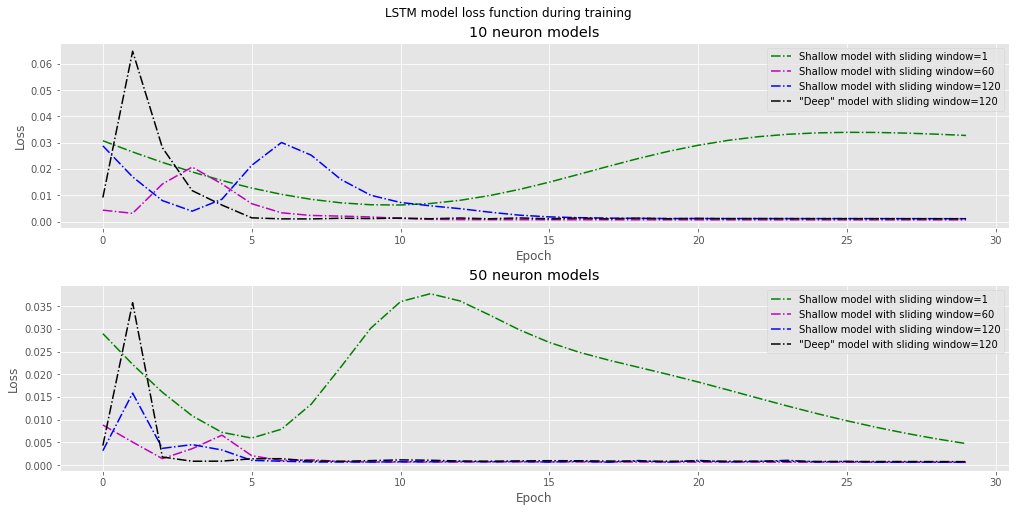

In [519]:
fig, axs = plt.subplots(2, constrained_layout=True)
fig.suptitle('LSTM model loss function during training')
cut=-1
axs[0].plot(LSTM_Models['10 neuron'][0].history['val_loss'],'g-.',label=Models['Names'][0])
axs[0].plot(LSTM_Models['10 neuron'][1].history['val_loss'],'m-.',label=Models['Names'][1])
axs[0].plot(LSTM_Models['10 neuron'][2].history['val_loss'],'b-.',label=Models['Names'][2])
axs[0].plot(LSTM_Models['10 neuron'][3].history['val_loss'],'k-.',label=Models['Names'][3])
axs[0].legend() 
axs[0].title.set_text('10 neuron models')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Epoch')

axs[1].plot(LSTM_Models['50 neuron'][0].history['val_loss'],'g-.',label=Models['Names'][0])
axs[1].plot(LSTM_Models['50 neuron'][1].history['val_loss'],'m-.',label=Models['Names'][1])
axs[1].plot(LSTM_Models['50 neuron'][2].history['val_loss'],'b-.',label=Models['Names'][2])
axs[1].plot(LSTM_Models['50 neuron'][3].history['val_loss'],'k-.',label=Models['Names'][3])
axs[1].legend() 
axs[1].title.set_text('50 neuron models')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')



Text(0.5, 0, 'Period')

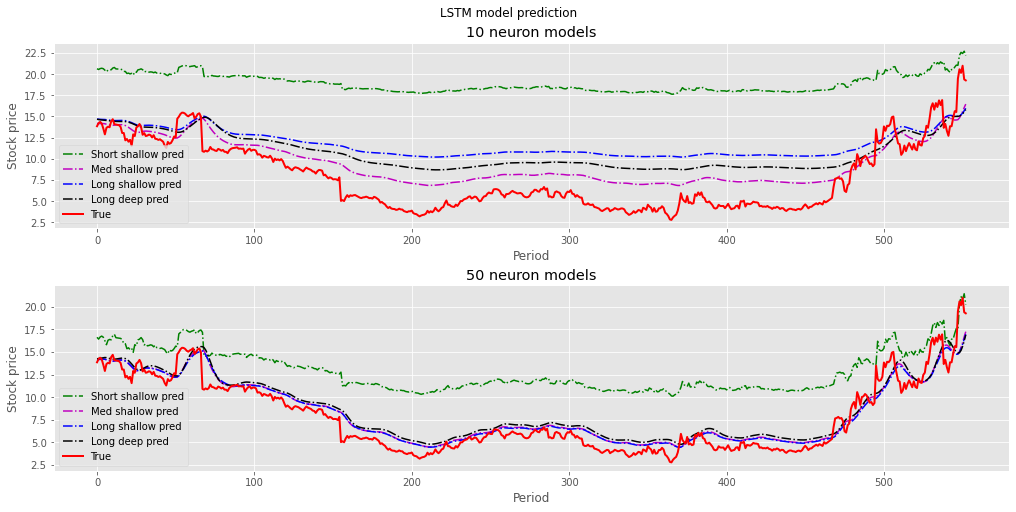

In [520]:
fig, axs = plt.subplots(2, constrained_layout=True)
fig.suptitle('LSTM model prediction')
cut=-1
axs[0].plot(LSTM_Preds['10 neuron'][0][:cut],'g-.',label='Short shallow pred')
axs[0].plot(LSTM_Preds['10 neuron'][1][:cut],'m-.',label='Med shallow pred')
axs[0].plot(LSTM_Preds['10 neuron'][2][:cut],'b-.',label='Long shallow pred')
axs[0].plot(LSTM_Preds['10 neuron'][3][:cut],'k-.',label='Long deep pred')
axs[0].plot(true_stock[:cut],'r',label='True',linewidth=2)
axs[0].legend() 
axs[0].title.set_text('10 neuron models')
axs[0].set_ylabel('Stock price')
axs[0].set_xlabel('Period')

axs[1].plot(LSTM_Preds['50 neuron'][0][:cut],'g-.',label='Short shallow pred')
axs[1].plot(LSTM_Preds['50 neuron'][1][:cut],'m-.',label='Med shallow pred')
axs[1].plot(LSTM_Preds['50 neuron'][2][:cut],'b-.',label='Long shallow pred')
axs[1].plot(LSTM_Preds['50 neuron'][3][:cut],'k-.',label='Long deep pred')
axs[1].plot(true_stock[:cut],'r',label='True',linewidth=2)
axs[1].legend() 
axs[1].title.set_text('50 neuron models')
axs[1].set_ylabel('Stock price')
axs[1].set_xlabel('Period')



In [521]:
preds_df=pd.DataFrame.from_dict(LSTM_Preds['10 neuron']).T
preds_df2=pd.DataFrame.from_dict(LSTM_Preds['50 neuron']).T

In [522]:
res_error=pd.DataFrame()
res_error2=pd.DataFrame()
for i in range(0,preds_df.shape[1]):
    res_error[Models['Names'][i]]=preds_df[i]-true_stock
    res_error2[Models['Names'][i]]=preds_df2[i]-true_stock

In [523]:
custom_pal={res_error.columns[0]: 'g', res_error.columns[1]: 'm',res_error.columns[2]:'b', res_error.columns[3]:'gray'}

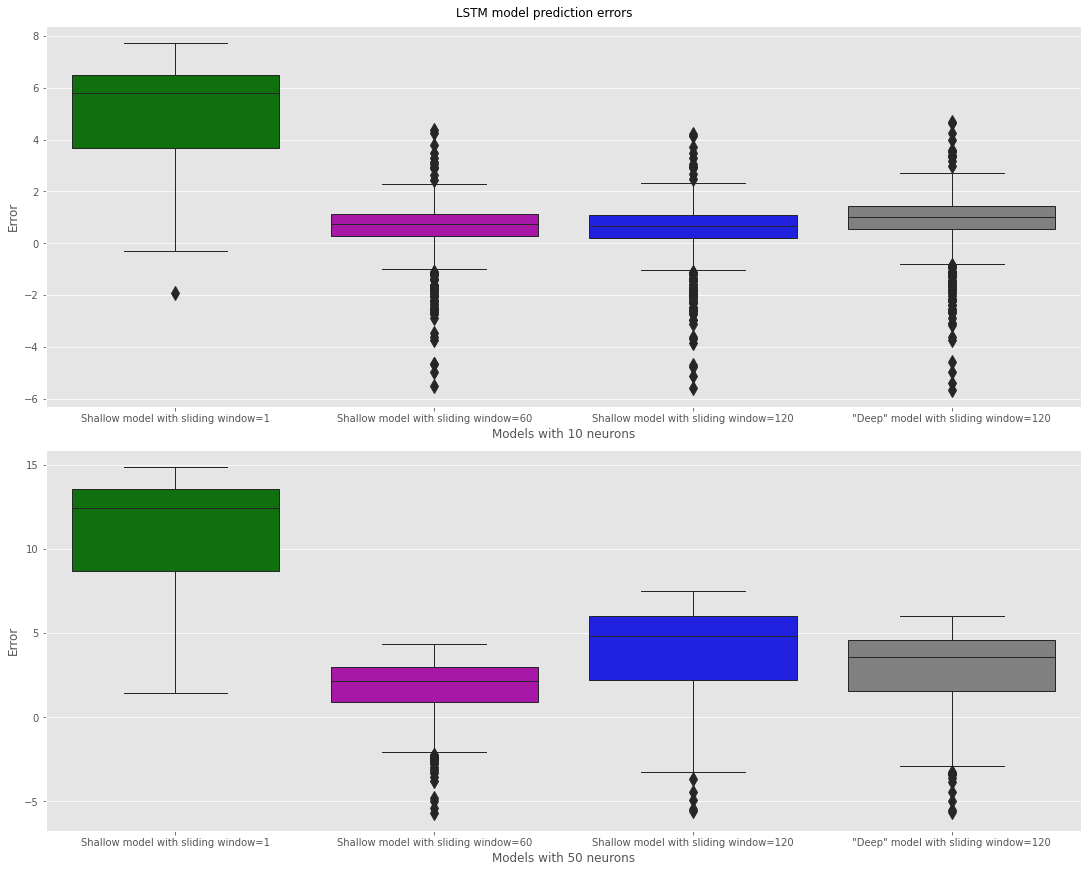

In [524]:
fig, axs = plt.subplots(2,figsize=(15,12), constrained_layout=True)
fig.suptitle('LSTM model prediction errors')
sns.boxplot(data=res_error2,linewidth=1,fliersize=10,palette=custom_pal,ax=axs[0]).set(ylabel="Error",xlabel="Models with 10 neurons")
sns.boxplot(data=res_error,linewidth=1,fliersize=10,palette=custom_pal,ax=axs[1]).set(ylabel="Error",xlabel="Models with 50 neurons")
plt.show()

In [525]:
ten_acc=pd.DataFrame(columns=Models['Names'],index=['RMSE','MAPE'])
fift_acc=pd.DataFrame(columns=Models['Names'])

for i in range(4):
    y_pred=LSTM_Preds['10 neuron'][i]
    y_true=true_stock
    ten_acc.loc['RMSE',Models['Names'][i]]=RMSE(y_true,y_pred)
    ten_acc.loc['MAPE',Models['Names'][i]]=MAPE(y_true,y_pred)
    
for i in range(4):
    y_pred=LSTM_Preds['50 neuron'][i]
    y_true=true_stock
    fift_acc.loc['RMSE',Models['Names'][i]]=RMSE(y_true,y_pred)
    fift_acc.loc['MAPE',Models['Names'][i]]=MAPE(y_true,y_pred)
    

In [526]:
display(ten_acc.style.set_caption('LSTM models with 10 neurons')),display(fift_acc.style.set_caption('LSTM models with 50 neurons'))

,Shallow model with sliding window=1,Shallow model with sliding window=60,Shallow model with sliding window=120,"""Deep"" model with sliding window=120"
RMSE,11.484228,2.382375,4.648305,3.617728
MAPE,198.57%,39.97%,80.95%,62.45%


,Shallow model with sliding window=1,Shallow model with sliding window=60,Shallow model with sliding window=120,"""Deep"" model with sliding window=120"
RMSE,5.334532,1.250412,1.254121,1.452211
MAPE,92.85%,15.80%,15.28%,20.00%


(None, None)

Text(0.5, 0, 'MAPE of LSTM with 50 neurons')

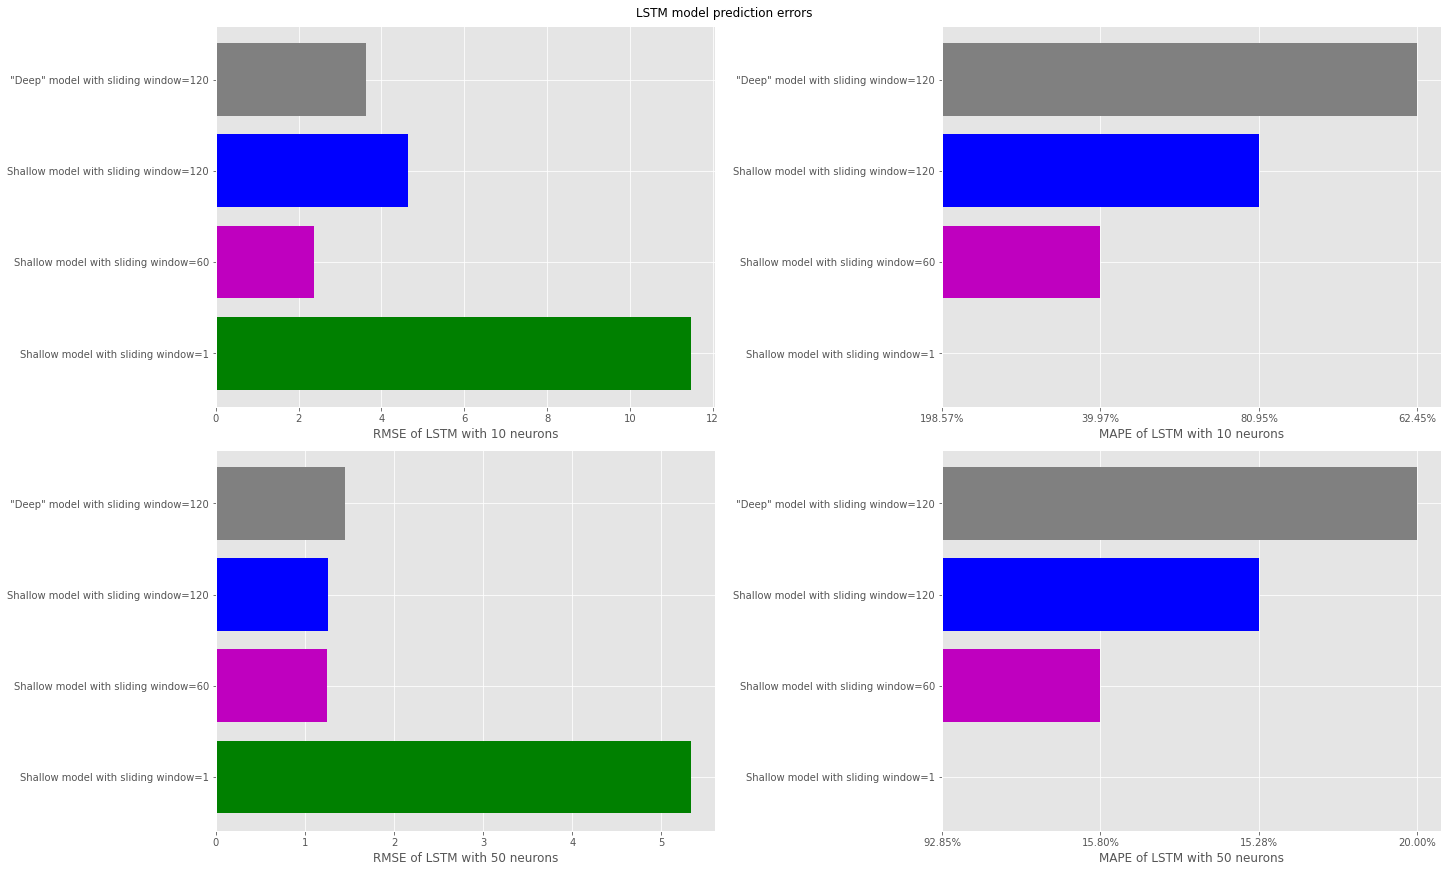

In [527]:
fig, axs = plt.subplots(2,2,figsize=(20,12), constrained_layout=True)
fig.suptitle('LSTM model prediction errors')
axs[0,0].barh(Models['Names'],ten_acc.iloc[0,:],color=colors)
axs[0,1].barh(Models['Names'],ten_acc.iloc[1,:],color=colors)
axs[1,0].barh(Models['Names'],fift_acc.iloc[0,:],color=colors)
axs[1,1].barh(Models['Names'],fift_acc.iloc[1,:],color=colors)
axs[0,0].set_xlabel('RMSE of LSTM with 10 neurons')
axs[0,1].set_xlabel('MAPE of LSTM with 10 neurons')
axs[1,0].set_xlabel('RMSE of LSTM with 50 neurons')
axs[1,1].set_xlabel('MAPE of LSTM with 50 neurons')